# Gaussian generative models for handwritten digit classification

## 1. Set up notebook and load in data

As usual, we start by importing the required packages and data. For this notebook we will be using the *entire* `MNIST` dataset. The code below defines some helper functions that will load `MNIST` onto your computer.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt 
import gzip, os
import numpy as np
from scipy.stats import multivariate_normal

from urllib.request import urlretrieve

In [3]:
# Function that downloads a specified MNIST data file from Yann Le Cun's website
def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)

# Invokes download() if necessary, then reads in images
def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1,784)
    return data

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

Now load in the training set and test set

In [4]:
## Load the training set
train_data = load_mnist_images('train-images-idx3-ubyte.gz')
train_labels = load_mnist_labels('train-labels-idx1-ubyte.gz')

## Load the testing set
test_data = load_mnist_images('t10k-images-idx3-ubyte.gz')
test_labels = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

The function **displaychar** shows a single MNIST digit. To do this, it first has to reshape the 784-dimensional vector into a 28x28 image.

In [5]:
def displaychar(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

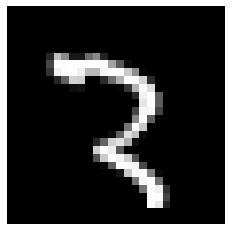

In [6]:
displaychar(train_data[500])

The training set consists of 60,000 images. Thus `train_data` should be a 60000x784 array while `train_labels` should be 60000x1. Let's check.

In [7]:
train_data = train_data.astype("int64")
test_data = test_data.astype("int64")

train_data = train_data[:int(len(train_data)*0.1),:]
train_labels = train_labels[:int(len(train_labels)*0.1)]

test_data = train_data[:int(len(test_data)*0.1),:]
test_labels = train_labels[:int(len(test_labels)*0.1)]

In [8]:
train_data.shape, train_labels.shape

((60000, 784), (60000,))

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(train_data, train_labels, test_size=0.20, random_state=42)

In [10]:
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((48000, 784), (12000, 784), (48000,), (12000,))

## 2. Fit a Gaussian generative model to the training data

**<font color="magenta">For you to do:</font>** Define a function, **fit_generative_model**, that takes as input a training set (data `x` and labels `y`) and fits a Gaussian generative model to it. It should return the parameters of this generative model; for each label `j = 0,1,...,9`, we have:
* `pi[j]`: the frequency of that label
* `mu[j]`: the 784-dimensional mean vector
* `sigma[j]`: the 784x784 covariance matrix

This means that `pi` is 10x1, `mu` is 10x784, and `sigma` is 10x784x784.

We have already seen how to fit a Gaussian generative model in the IRIS example, but now there is an added ingredient. <font color="magenta">The empirical covariances are very likely to be singular (or close to singular), which means that we won't be able to do calculations with them</font>. Thus it is important to **regularize** these matrices. The standard way of doing this is to add `cI` to them, where `c` is some constant and `I` is the 784-dimensional identity matrix. (To put it another way, we compute the empirical covariances and then increase their diagonal entries by some constant `c`.)

This modification is guaranteed to yield covariance matrices that are non-singular, for any `c > 0`, no matter how small. But this doesn't mean that we should make `c` as small as possible. Indeed, `c` is now a hyper-parameter, and by setting it appropriately, we can improve the performance of the model.

Your routine needs to choose a good setting of `c`. Crucially, this needs to be done using the training set alone. So you might try setting aside part of the training set as a validation set, or using some kind of cross-validation.

In [11]:
def fit_generative_model(x, y, c):
    ### UPDATE CODE HERE ###
    #c = 100
    k = 10  # labels 0,1,...,k-1
    d = (x.shape)[1]  # number of features
    mu = np.zeros((k,d))
    sigma = np.zeros((k,d,d))
    pi = np.zeros(k)
    for label in range(0,k):
        indices = (y == label)
        ### START CODE HERE ###
        mu[label] = x[indices,:].mean(axis = 0)
        sigma[label] = np.cov(x[indices,:], rowvar=False)
        ### Update Code for regularization (smoothing)
        sigma[label] = sigma[label] + c*np.identity(d)
        pi[label] = len(x[indices,:]) / len(y)
        ### END CODE HERE ###
    return mu, sigma, pi

Okay, let's try out your function. In particular, we will use **displaychar** to visualize the means of the Gaussians for the first three digits. You can try the other digits on your own.

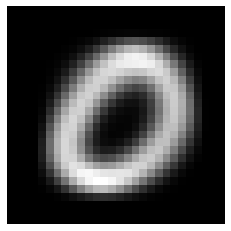

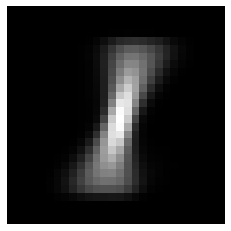

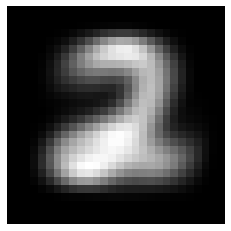

In [13]:
mu, sigma, pi = fit_generative_model(X_train, Y_train, 1000000000000)

displaychar(mu[0])
displaychar(mu[1])
displaychar(mu[2])

In [144]:
print(mu.shape)
print(sigma.shape)
print(pi.shape)

(10, 784)
(10, 784, 784)
(10,)


## 3. Make predictions on validate data

Now let's see how many errors your model makes on the validate set.

In [145]:
def NormalPDF(x, mu, ConstantPart, invCovar, pi):
    
    expPart = np.matmul(np.matmul(-0.5 *np.transpose(x - mu), invCovar), x-mu)
    #expPart = np.log(expPart)
    #consPart = ConstantPart
    #consPast = np.log(consPart)
    #res = pi * (expPart - consPart)
    res = expPart - (ConstantPart) + np.log(pi)
    
    return res
# def NormalPDF(x, mu, covar, pi):
#     d = len(mu)
#     expPart = np.matmul(np.matmul(-0.5 *np.transpose(x - mu), np.linalg.inv(covar)), x-mu)
#     pa1 = (d/2)*np.log(2+np.pi)
#     pa2 = np.sqrt(np.linalg.det(covar))
#     res = np.log(pi) + expPart - (pa1 + pa2)
#     return res

In [146]:
# Compute log Pr(label|image) for each [val image,label] pair.
k = 10
score = np.zeros((Y_val.shape[0],k))
for label in range(0,k):
    invCovar = np.linalg.inv(sigma[label])
    d = len(mu[label])
    #ConstantPart = (np.power(2*np.pi, d/2)* np.sqrt(np.linalg.det(sigma[label])))
    ConstantPart = (d/2) * np.log(2*np.pi) + 0.5 * np.linalg.slogdet(sigma[label])[1]
    for i in range(0,Y_val.shape[0]):
       ### START CODE HERE ###
       #score[i,label] = multivariate_normal.logpdf(X_val[i], mu[label], sigma[label]) * pi[label]
        score[i,label] = NormalPDF(X_val[i], mu[label], ConstantPart, invCovar, pi[label])

predictions = np.argmax(score, axis = 1)



### END CODE HERE ###
# Finally, tally up score
errors = np.sum(predictions != Y_val)
print ("Your model makes " + str(errors) + " errors out of 12000")
print("Accuracy = " + str((12000-errors)/12000*100))

Your model makes 10678 errors out of 12000
Accuracy = 11.016666666666666


In [147]:
def Pick_C(c):
    mu, sigma, pi = fit_generative_model(X_train, Y_train, c)
    k = 10
    score = np.zeros((Y_val.shape[0],k))
    for label in range(0,k):
        invCovar = np.linalg.inv(sigma[label])
        d = len(mu[label])
        #ConstantPart = (np.power(2*np.pi, d/2)* np.sqrt(np.linalg.det(sigma[label])))
        ConstantPart = (d/2) * np.log(2*np.pi) + 0.5 * np.linalg.slogdet(sigma[label])[1]
        for i in range(0,Y_val.shape[0]):
           ### START CODE HERE ###
           #score[i,label] = multivariate_normal.logpdf(X_val[i], mu[label], sigma[label]) * pi[label]
            score[i,label] = NormalPDF(X_val[i], mu[label], ConstantPart, invCovar, pi[label])

    predictions = np.argmax(score, axis = 1)



    ### END CODE HERE ###
    # Finally, tally up score
    errors = np.sum(predictions != Y_val)
    print("C = %d"%(c))
    print ("Your model makes " + str(errors) + " errors out of 12000")
    print("Accuracy = " + str((12000-errors)/12000*100))

In [148]:
c = [100, 150, 300, 500, 700, 1000, 1500, 2000, 3000]

for i in c:
    Pick_C(i)

C = 100
Your model makes 1045 errors out of 12000
Accuracy = 91.29166666666667
C = 150
Your model makes 948 errors out of 12000
Accuracy = 92.10000000000001
C = 300
Your model makes 807 errors out of 12000
Accuracy = 93.27499999999999
C = 500
Your model makes 724 errors out of 12000
Accuracy = 93.96666666666667
C = 700
Your model makes 684 errors out of 12000
Accuracy = 94.3
C = 1000
Your model makes 633 errors out of 12000
Accuracy = 94.72500000000001
C = 1500
Your model makes 598 errors out of 12000
Accuracy = 95.01666666666667
C = 2000
Your model makes 581 errors out of 12000
Accuracy = 95.15833333333333
C = 3000
Your model makes 583 errors out of 12000
Accuracy = 95.14166666666667


## 4. Make predictions on test data

In [149]:
mu, sigma, pi = fit_generative_model(X_train, Y_train, 2000)

In [151]:
# Compute log Pr(label|image) for each [val image,label] pair.
k = 10
score = np.zeros((test_labels.shape[0],k))
for label in range(0,k):
    invCovar = np.linalg.inv(sigma[label])
    d = len(mu[label])    
    ConstantPart = (d/2) * np.log(2*np.pi) + 0.5 * np.linalg.slogdet(sigma[label])[1]
    for i in range(0,test_labels.shape[0]):
       ### START CODE HERE ### 
       score[i,label] = NormalPDF(test_data[i], mu[label], ConstantPart, invCovar, pi[label])
predictions = np.argmax(score, axis = 1)
### END CODE HERE ###
# Finally, tally up score
errors = np.sum(predictions != test_labels)
total_count = test_labels.shape[0]
print ("Your model makes " + str(errors) + " errors out of " + str(total_count))
print("Accuracy = " + str((total_count-errors)/total_count*100))

Your model makes 439 errors out of 10000
Accuracy = 95.61


## 4. Quick exercises

<font color="magenta">Exercise 1:</font> What happens if you do not regularize the covariance matrices?

<font color="magenta">Exercise 2:</font> What happens if you set the value of `c` too high, for instance to one billion? Do you understand why this happens?

<font color="magenta">Exercise 3:</font> What value of c did you end up using? How many errors did your model make on the validation set?

<font color="magenta">Exercise 4:</font> How many errors did your model make on the test set?

<font color="magenta">Optional</font>: 
1. We have talked about using the same regularization constant `c` for all ten classes. What about using a different value of `c` for each class? How would you go about choosing these? Can you get better performance in this way?
2. Try applying multivariate Gaussian classifier on other datasets.